<a href="https://www.kaggle.com/code/dimasjackson/supernovae-analysis-with-mcmc?scriptVersionId=175618278" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Supernovae Analysis with Markov Chain Monte Carlo

### Abstract

In this project we will use the Pantheon+SH0ES luminosity distances data of 1701 Supernovae to estimate cosmological parameters. The parameters that we are interested in are the Hubble constant $H_0$, the matter density fraction $\Omega_m$ and the dark energy fraction $\Omega_\Lambda$, which is responsible for the accelerated expansin of the universe. The bayesian statistics will be adopted to calculate the posterior probability distribution of the parameters using the likelihood distribution and the prior probability. The likelihood for a set of cosmological parameters will be computed given the experimental supernovae distances. Also, we will implement the emcee algorithm to generate samples with a Markov Chain Monte Carlo (MCMC) model starting from the parameters values that maximize the likelihood. Finally, the results will be plotted in the space of parameters and the best values estimated avereging over some percentile of the samples.

# Installing emcee

First we will install the most recently version of [emcee](https://emcee.readthedocs.io/en/stable/) library and the package Corner for corner plots. The emcee is an MIT licensed pure-Python implementation of Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler that will be used to estimate the posterior probability function. 

In [1]:
#Installing the EMCEE - Markov Chain Monte Carlo library
!pip install -U emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 905.5 kB/s eta 0:00:00


In [2]:
# Installing the Corner plot module
! python -m pip install corner

In [3]:
# Settingplots in the notebook from matplotlib
%matplotlib inline

import numpy as np # Import numpy for linear algebra computations
import matplotlib.pyplot as plt # Import Matplotlib and seabor to create plots
import seaborn as sns
import pandas as pd # Import pandas to handle the data set

In [4]:
# Import the EnsembleSampler to generate samples of a Markov Chain and the corner plot
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from corner import corner
import sys

We will load the data of 1701 supernovae events from the [Phanteon+SH0ES Git Hub Data Release](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR) colaboration, download the data and set your directory properly.

In [5]:
df = pd.read_table("/kaggle/input/supernovae-pantheonsh0es-data/PantheonSH0ES.dat", sep="\s+")

In [6]:
df.head()

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


In [7]:
df.shape

(1701, 47)

We are interested in the distance modulos data as a function of the redshift in the Cosmic Microwave Background (CMB) refeerence system.

Text(0, 0.5, 'Distance Modulus')

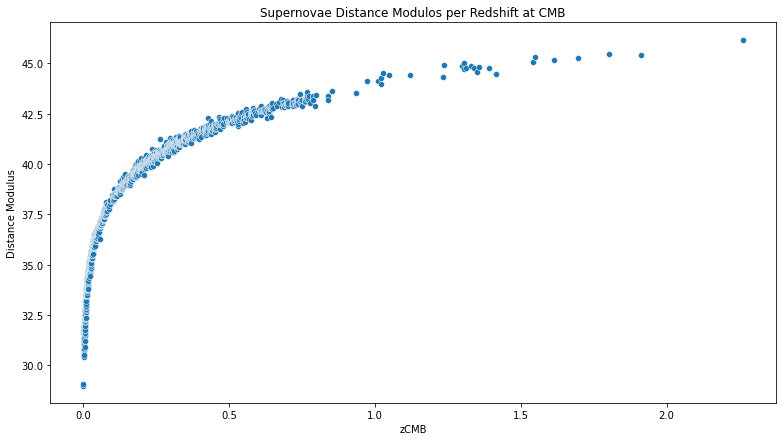

In [8]:
plt.figure(figsize=(13,7))
sns.scatterplot(x=df['zCMB'], y=df['MU_SH0ES']).set(title='Supernovae Distance Modulos per Redshift at CMB')
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

# Defining the Theoretical Model

In [9]:
# Defining the cosmological density parameters (just our first guess)
h_guess = 0.67
Omega_Lambda_guess, Omega_m_guess, H0_guess, = 0.69, 0.31, h_guess*100/(3.086*10**19) #H0 in 1 over secconds

It is important to note that we will estimate the parameter $h$ defined by
$$ H_0 = h\times 100 {\rm Km/sMpc}$$
because $h$ is of the same order of magnitude of $\Omega_m$ and $\Omega_\Lambda$.

Our first guess to the cosmological parameters that will be estimated is:

In [10]:
print('Omega_Lambda_guess = {:.2f}'.format(Omega_Lambda_guess))
print('Omega_m_guess = {:.2f}'.format(Omega_m_guess))
print('h_guess = {:.2f}'.format(h_guess))

Omega_Lambda_guess = 0.69
Omega_m_guess = 0.31
h_guess = 0.67


The luminosity distance in a flat expanding Friedmann-Lemaitre-Robertson-Walker university is given by:
$$ d_L = (1+z)d_H \int_{0}^{z}dz^{\prime} \left[ \Omega_r(1+z^{\prime})^4 + \Omega_m(1+z^{\prime})^3+ \Omega_{\Lambda} \right]^{-1/2} \,,$$
where $d_H=c/H_0$ is the Hubble distance.

To calculate the luminosity distance it is necessary to perform a numerical integration

In [11]:
# Importing the numerical integration package
from scipy.integrate import quad

In [12]:
# The function we want to integrate
def f(z, Omega_Lambda, Omega_m):
    Omega_r = 9*10**(-5)
    return 1/(np.sqrt(Omega_r*(1+z)**4+Omega_m*(1+z)**3+Omega_Lambda))

In [13]:
# call quad to numerical integrate f using quadrature method and store the results in a list
L=[]
for z in np.arange(0.001, 2.5, 0.0014):
    res, err = quad(f, 0, z, args=(Omega_Lambda_guess, Omega_m_guess)) # I discarted the integration error, but it can be stored
    L.append(res)
len(L)

1785

In [14]:
cLight = 2.997*10**8 # Speed of light in vacuum
dH = cLight/H0_guess # Hubble length in Mpc

In [15]:
# Calculating the luminosity distance
z_list=[]
for z in np.arange(0.001,2.5,0.0014):
    z_list.append(z)
dL=[]
for k in np.arange(0, 1785):
    dL.append(dH*(1+z_list[k])*L[k]/(3*10**22))
print(len(z_list))
print(len(dL))

1785
1785


What is actually measured is the distance modulos, defined by
$$ \mu = 5 [\log_{10}{(d_L)} + 5] $$

In [16]:
# Calculating the distance modulos
mu_model=[]
for k in range(0, 1701):
    mu_model.append((5*(np.log10(np.abs(dL[k])) + 5)))
len(mu_model)

1701

In [17]:
# The z_list array and the distance modulus must be the same length, so we will discard the remaining points
del z_list[1701:1785]
len(z_list)

1701

In [18]:
# Numerical interpolation of the results
from scipy.interpolate import interp1d # Interpolation function

mu_model_inter = interp1d(z_list, mu_model, kind='cubic')

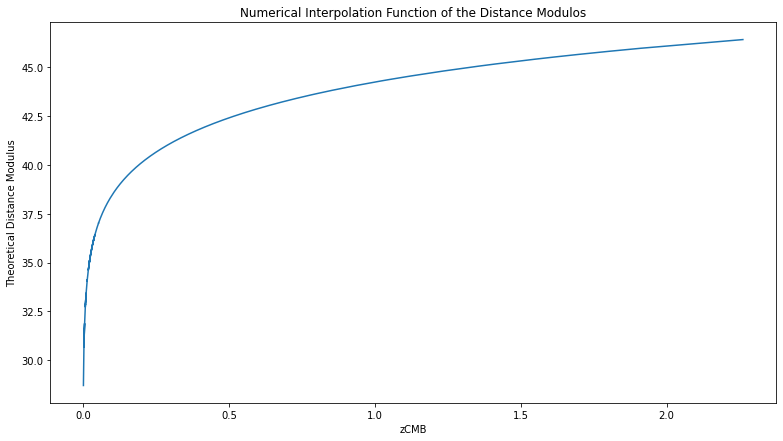

In [19]:
# Plot the numerical interpolation function of the theoretical model
z_var = df['zCMB']
plt.figure(figsize=(13,7))
plt.plot(z_var, mu_model_inter(z_var))
plt.title("Numerical Interpolation Function of the Distance Modulos")
plt.xlabel("zCMB")
plt.ylabel("Theoretical Distance Modulus")
plt.savefig('theo_dist.png')

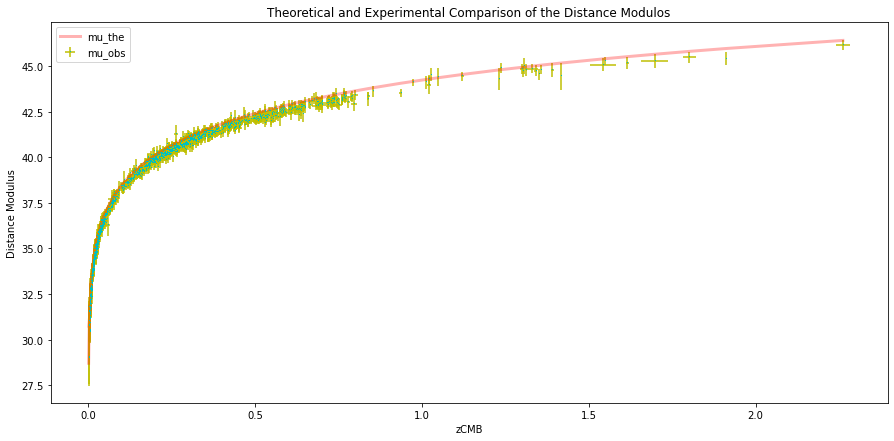

In [20]:
# Plot the theoretical experimental comparison of the distance modulos
plt.figure(figsize=(15,7))

# Plot the data points and error bars
x_exp=df['zCMB']
y_exp=df['MU_SH0ES']
plt.errorbar(x_exp, y_exp, xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt=",c", ecolor="y", capsize=0)

# Plot the true line
y_theo=mu_model_inter
plt.plot(x_exp, y_theo(x_exp), "r", alpha=0.3, lw=3)

plt.title("Theoretical and Experimental Comparison of the Distance Modulos")
legend = ("mu_the", "mu_obs")
plt.legend(legend)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")
plt.savefig('dist_modulus.png')

This is a comparison between theoretical and experimental distance modulos of 1701 supernovae. The error bars comes from the Pantheon+SH0ES data, the uncertainty on MU_SH0ES was determined from the diagonal of the covariance matrix and are only for plot purpose, cannot be used to fit cosmological parameters.

# Implementing the Model in a Pipeline

In [21]:
def mu_model_pipe(Omega_Lambda, Omega_m, h):
    L=[]
    for z in np.arange(0.001, 2.5, 0.0014):
        res, err = quad(f, 0, z, args=(Omega_Lambda, Omega_m)) # I discarted the integration error, but it can be stored
        L.append(res)
    H0 = h*100/(3.086*10**19)
    cLight = 2.997*10**8 # Speed of light in vacuum
    dH = cLight/H0 # Hubble length in Mpc
    # Calculating the luminosity distance
    z_list=[]
    for z in np.arange(0.001,2.5,0.0014):
        z_list.append(z)
    dL=[]
    for k in np.arange(0, 1785):
        dL.append(dH*(1+z_list[k])*L[k]/(3*10**22))
    # Calculating the distance modulus
    mu_model=[]
    for k in range(0, 1701):
        mu_model.append((5*(np.log10(np.abs(dL[k])) + 5)))
    del z_list[1701:1785]
    mu_model_inter = interp1d(z_list, mu_model, kind='cubic')
    return mu_model_inter

In [22]:
mu_test = mu_model_pipe(Omega_Lambda_guess, Omega_m_guess, h_guess)

Text(0, 0.5, 'Theoretical Distance Modulus')

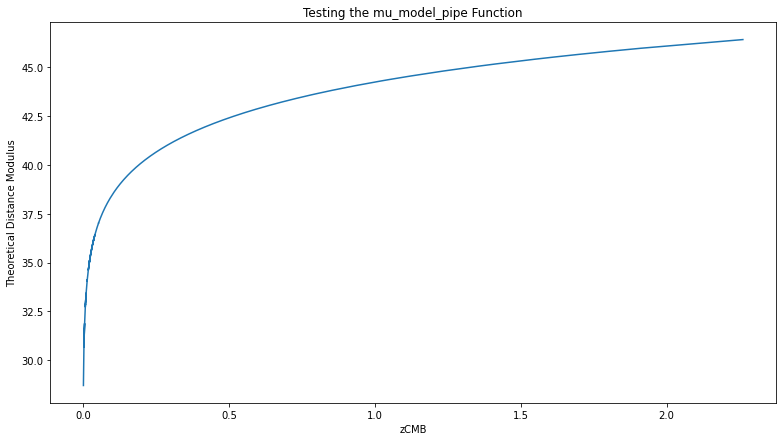

In [23]:
# Testing the mu_model_pipe function
plt.figure(figsize=(13,7))
plt.plot(z_var, mu_test(z_var))
plt.title("Testing the mu_model_pipe Function")
plt.xlabel("zCMB")
plt.ylabel("Theoretical Distance Modulus")

# Importing the Covariance Matrix

The covariance matrix will be imported from the [Pantheon+SH0ES Git Hub Data Release](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR). The format of the covariance (.cov) file is NxN lines where the matrix should be read in sequentially.  The first line gives the number of rows/columns in the matrix (N=1701).  The STATONLY matrix has only elements that correspond to the statistical distance uncertainties for individual SNe. This includes intrinsic scatter off-diagonal components when the light-curves represent the same SN observed by different surveys.

In [24]:
cov_aux = pd.read_table('/kaggle/input/pantheon-cov-matrix/Pantheon%2BSH0ES_STAT%2BSYS.cov')
cov_aux.head()

,1701
0,0.031771
1,0.005754
2,0.000310
3,0.001187
4,0.000083


In [25]:
cov_aux.shape

(2893401, 1)

In [26]:
cov_matrix = [] # Read the covariance matrix and store in a array
for i in range(1701):
    row = []
    for j in range(1701*i,1701*(i+1)):
        row.append(cov_aux['1701'][j])
    cov_matrix.append(row)

In [27]:
len(cov_matrix)

1701

In [28]:
cov_matrix[0][0]

0.03177108

In [29]:
cov_matrix[1700][1700]==cov_aux['1701'][2893400] # Verifying if the matrix was read with succes

True

In [30]:
cov_matrix = np.array(cov_matrix) # Converting the matrix list into a Numpy array format 
cov_matrix[0]

array([ 3.177108e-02,  5.754430e-03,  3.100600e-04, ...,  2.945500e-04,
       -8.595000e-05, -2.701100e-04])

In [31]:
cov_matrix.shape

(1701, 1701)

In [32]:
inv = np.linalg.inv(cov_matrix) # Calculating the inverse matrix
inv.shape

(1701, 1701)

In [33]:
inv[0] # Print the first line of the inverse

array([ 3.35405114e+01, -5.68645204e+00, -1.07870284e-01, ...,
        1.44562418e-02,  1.73619146e-02,  6.56463541e-02])

In [34]:
np.linalg.eig(cov_matrix)[1] # Calculates the eigenvalues of the covariance matrix

array([[-2.96148587e-03, -2.18443140e-02,  9.91981514e-04, ...,
         9.64893133e-04,  3.19053813e-04,  5.91684316e-05],
       [-1.72476998e-03,  1.90502948e-03, -1.45654135e-02, ...,
         5.69425676e-05, -5.51999401e-04, -3.43874555e-03],
       [-3.25782834e-02,  1.53065947e-02,  1.09858778e-02, ...,
         1.54613492e-03, -1.32184742e-03, -6.56669952e-03],
       ...,
       [-2.86966100e-02, -2.16020537e-02, -1.08898760e-03, ...,
        -1.15688499e-03,  2.78073191e-04, -2.23892355e-03],
       [-4.30813218e-02,  3.33182559e-03, -2.80048267e-03, ...,
        -1.28031502e-03,  2.56683754e-04, -9.61990704e-04],
       [-5.31572832e-02,  5.55188533e-03, -9.28158623e-03, ...,
        -4.79416272e-03,  1.30874885e-03, -2.37309350e-03]])



In [35]:
def log_likelihood(theta, mu_data, cov):
    """Compute the Gaussian log-likelihood for a given distance modulus data, distance modulus theorical and covariance."""
    Omega_Lambda, Omega_m, h = theta
    cov_inv = np.linalg.inv(cov)
    cov_eigvals = np.linalg.eig(cov)
    cov_len = len(cov)
    mu_model_array=[]
    mu_aux = mu_model_pipe(Omega_Lambda, Omega_m, h)
    for z in z_var:
        mu_model_array.append(mu_aux(z))
    mu_model_array=np.array(mu_model_array)
    return -0.5 * (np.matmul((mu_model_array - mu_data) , np.matmul(cov_inv , (mu_model_array - mu_data)))) - .5 * (np.sum(np.log(np.absolute(cov_eigvals[1]))) + cov_len * np.log(2*np.pi))

In [36]:
# Testing the log_likelihood:
mu_data = np.array(df['MU_SH0ES'])
cov=cov_matrix
theta = (Omega_Lambda_guess, Omega_m_guess, h_guess)
log_likelihood(theta, mu_data, cov)

9512978.855685467

Now, the scipy minimize function will be used to compute the parameters $\Omega_\Lambda, \Omega_m, h$ that optimizes the likelihood for the given data. It’s worth noting that the optimize module minimizes functions whereas we would like to maximize the likelihood. This goal is equivalent to minimizing the negative likelihood (or in this case, the negative log likelihood).

In [37]:
# Defining a random value to start the optimization
np.random.seed(62) # Generate a random number from 62
random_vec = 0.01*np.absolute(np.random.randn(3))
initial = np.array([Omega_Lambda_guess, Omega_m_guess, h_guess]) - random_vec 
initial

array([0.68987675, 0.30472419, 0.66712409])

In [38]:
# Define the boundary values for the parameters:
Omega_Lambda_min = 0.67
Omega_Lambda_max = 0.71
Omega_m_min = 0.29
Omega_m_max = 0.33
h_min = 0.65 
h_max = 0.69

theta_min = (Omega_Lambda_min,Omega_m_min,h_min)
theta_max = (Omega_Lambda_max,Omega_m_max,h_max)

bnds = (theta_min, theta_max)

print(bnds)

((0.67, 0.29, 0.65), (0.71, 0.33, 0.69))


In [39]:
# Set the bounds in a properly format
from scipy.optimize import Bounds
bd = Bounds(lb=theta_min, ub=theta_max)
bd

Bounds(array([0.67, 0.29, 0.65]), array([0.71, 0.33, 0.69]))

Now we will maximize the likelihood distribution, **the next step may take a few minutes!**

In [40]:
from scipy.optimize import minimize # Minimization of scalar function

mu_data = np.array(df['MU_SH0ES']) # Load the experimental data for distance modulus
cov = cov_matrix

neg_like = lambda *args: -log_likelihood(*args) # Define the negative likelihood function: minimze negative log likelihood = maximize log likelihood

# Optimize the negative likelihood
soln = minimize(neg_like, initial, args=(mu_data, cov), method='Nelder-Mead', bounds=bd)
Omega_Lambda_ml, Omega_m_ml, h_ml = soln.x # Store the parameters that optimizes the likelihood

print("Optimized likelihood estimates:")
print("Omega_Lambda = {:.2f}".format(Omega_Lambda_ml))
print("Omega_m = {:.2f}".format(Omega_m_ml))
print("H0[Km/sMpc] = {:.2f}".format(h_ml*100)) # Print H0 in km/sMpc

Optimized likelihood estimates:
Omega_Lambda = 0.71
Omega_m = 0.33
H0[Km/sMpc] = 69.00


Although the $\Omega_\Lambda$ and $\Omega_m$ didn't summed to 1, this constraint will be included in the total probability. 

Text(0, 0.5, 'Distance Modulus')

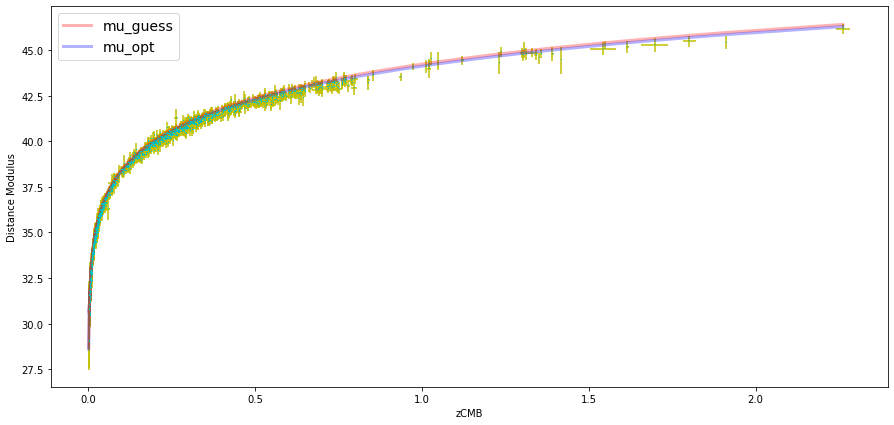

In [41]:
# Plot the mu_theoretical calculated using the parameters that maximize the likelihood
plt.figure(figsize=(15,7))

# Plot the error bars
z_exp=df['zCMB']
mu_exp=df['MU_SH0ES']
plt.errorbar(z_exp, mu_exp, xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt=",c", ecolor="y", capsize=0)

# Plot the theoretical model with guess parameters
mu_guess=mu_model_pipe(Omega_Lambda_guess, Omega_m_guess, h_guess)
plt.plot(z_var, mu_guess(z_exp), "r", alpha=0.3, lw=3, label="mu_guess")

# Plot the theoretical model with optimized parameters
mu_opt = mu_model_pipe(Omega_Lambda_ml, Omega_m_ml, h_ml)
plt.plot(z_var, mu_opt(z_var), "b", alpha=0.3, lw=3, label="mu_opt")
plt.legend(fontsize=14)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

We can see that the mu_optimized fits better the distance data than the mu_guess. 

Let's calculate the residues:

$$\chi^2_\nu = \frac{\chi^2} \nu,$$
where the chi-squared is a weighted sum of squared deviations:
$$\chi^2 = \sum_{i} {\frac{(O_i - C_i)^2}{\sigma_i^2}}$$

with inputs: variance $\sigma _{i}^{2}$, observations $O$, and calculated data $C$. The degree of freedom, $\nu =n-m$, equals the number of observations $n$ minus the number of fitted parameters $m$.

In [42]:
# Creating a array of calculated mu data
mu_mod = []
mu_mod.append(mu_opt(z_exp))
mu_mod = np.array(mu_mod)

# Creating a array of calculated mu data
mu_mod_guess = []
mu_mod_guess.append(mu_guess(z_exp))
mu_mod_guess = np.array(mu_mod_guess)

In [43]:
len(mu_mod[0])

1701

In [44]:
# Chi-square statistic  
#  sd : uncertainties in mu data (standard deviation) 
chisq=np.sum(((mu_exp-mu_mod[0])/np.std(mu_exp))**2) 

# Number of degrees of freedom nu equals the number of observations n minus the number of fitted parameters 
nu=mu_exp.size-3 

# Reduced Chi Squared Statistics
reduced_chisq = chisq/nu

# Guess
#  sd : uncertainties in mu data (standard deviation) 
chisq_guess=np.sum(((mu_exp-mu_mod_guess[0])/np.std(mu_exp))**2) 

# Number of degrees of freedom nu equals the number of observations n minus the number of fitted parameters 
nu=mu_exp.size-3 

# Reduced Chi Squared Statistics
reduced_chisq_guess = chisq_guess/nu

In [45]:
reduced_chisq_guess

0.00827909469581476

In [46]:
reduced_chisq

0.004699070631813696

Comparing the value of the reduced Chi-Squared for the optimized theoretical model and our first guess we can see that the optimized is much smaller. A smaller value of reduced chi squared in general indicates a better fit of the model to the data, but may also indicate a overfitting, where the model is fitting noise in the data rather than capturing the underlying trend. Therefore, while aiming for a small reduced chi-squared value is generally desirable, it's crucial to balance model complexity and goodness of fit to avoid overfitting.

In [47]:
residues_guess = mu_exp-mu_mod_guess[0]

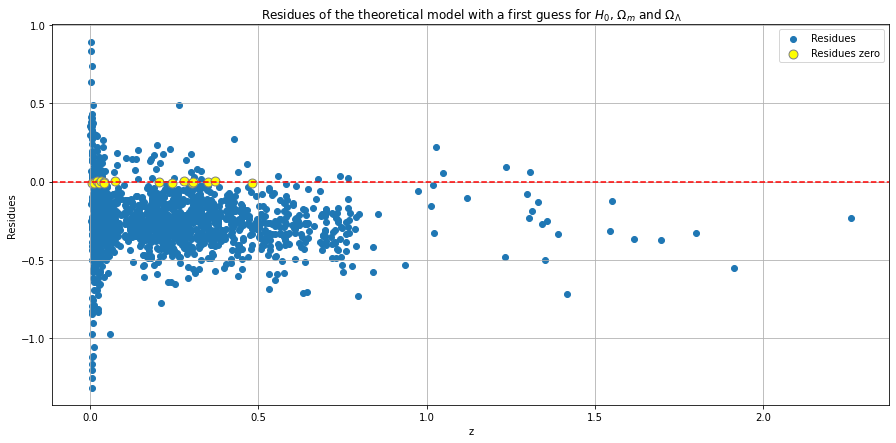

In [48]:
# Plot the residues
plt.figure(figsize=(15,7))

zero_indices = np.where((-0.01 <= residues_guess) & (residues_guess <= 0.01))[0]

plt.scatter(z_exp, residues_guess, label='Residues')
plt.axhline(0, color='red', linestyle='--')
plt.scatter(z_exp[zero_indices], residues_guess[zero_indices], s=80, color='yellow', edgecolor='gray', label='Residues zero')

plt.xlabel('z')
plt.ylabel('Residues')
plt.title('Residues of the theoretical model with a first guess for $H_0$, $\Omega_m$ and $\Omega_\Lambda$')

plt.legend()
plt.grid(True)

In [49]:
# Number of binned points
len(zero_indices)

16

In [50]:
residues = mu_exp-mu_mod[0]

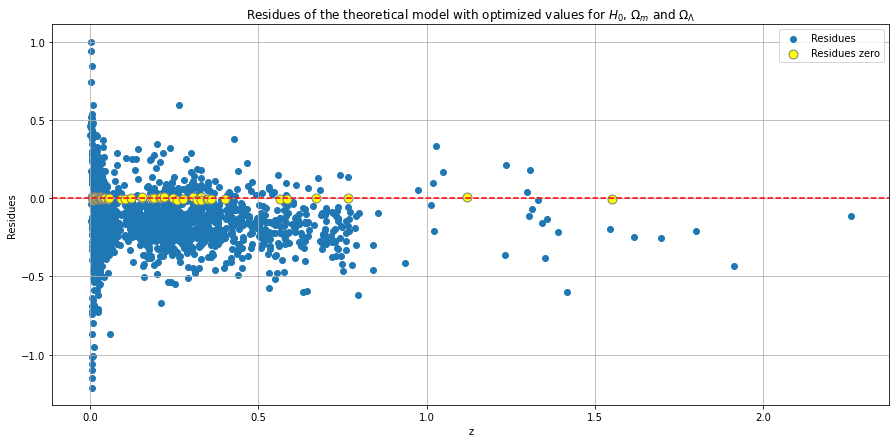

In [51]:
# Plot the residues
plt.figure(figsize=(15,7))

zero_indices = np.where((-0.01 <= residues) & (residues <= 0.01))[0]

plt.scatter(z_exp, residues, label='Residues')
plt.axhline(0, color='red', linestyle='--')
plt.scatter(z_exp[zero_indices], residues[zero_indices], s=80, color='yellow', edgecolor='gray', label='Residues zero')

plt.xlabel('z')
plt.ylabel('Residues')
plt.title('Residues of the theoretical model with optimized values for $H_0$, $\Omega_m$ and $\Omega_\Lambda$')

plt.legend()
plt.grid(True)


In [52]:
# Number of binned points
len(zero_indices)

55

There are 55 points with zero residues (very good fit) in optimized model and only 16 points in our first guess model, thus the values for $H_0$, $\Omega_m$ and $\Omega_\Lambda$ that minimizes the likelyhood generates a better fit to data. 

## Posterior Probability

In this section we will sample the posterior probability using the algorithm EMCEE to implement the Markov Chain Monte Carlo method. According to Bayes Theorem, the posterior probability is given by:
$$  p(\theta|\vec{x}) \propto p(\theta)\mathcal{L}(\vec{x}|\theta)\,, $$

where $\theta$ is the cosmological parameters vector, $\vec{x}$ the input data and $\mathcal{L}(\vec{x}|\theta)$ is the likelihood function.

In [53]:
# Defining the prior probability function

def log_prior(theta):
    Omega_Lambda, Omega_m, h = theta # Initial parameters guess
    if 0.67 < Omega_Lambda < 0.71 and 0.29 < Omega_m < 0.33 and 0.65 < h < 0.69 and Omega_m+Omega_Lambda==1:
        return 0.0
    return -np.inf

In [54]:
# Defining the full log-probability function

def log_probability(theta, mu_data, cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, mu_data, cov)

We’ll start by initializing the walkers in a tiny Gaussian ball around the maximum likelihood result and then run 10,000 steps of MCMC using 2000 walkers.

In [55]:
# Define the initial position
pos = soln.x + 10**(-1)*np.random.randn(2000, 3)
nwalkers, ndim = pos.shape
pos

array([[0.82234004, 0.1877776 , 0.77940256],
       [0.55732013, 0.35404082, 0.62579072],
       [0.86922023, 0.34037274, 0.73317814],
       ...,
       [0.64279235, 0.26311521, 0.556773  ],
       [0.69204164, 0.25102397, 0.5361604 ],
       [0.61494182, 0.48595894, 0.68923836]])

**Warning: This step may take several minutes!**

In [56]:
# Generating samples with emcee
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mu_data, cov))
sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [05:04<00:00, 32.83it/s]


# Plotting the Parameters Estimatitive

About 40 steps are needed for the chain to “forget” where it started. Let’s discard the initial 100 steps, thin by about 15 steps, and flatten the chain so that we have a flat list of samples:

In [57]:
# get_chain attribute from EnsembleSampler emcee:
# flat – Flatten the chain across the ensemble. (default: False)
# thin – Take only every thin steps from the chain. (default: 1)
# discard – Discard the first discard steps in the chain as burn-in. (default: 0)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["\Omega_\Lambda", "\Omega_m", "h"]

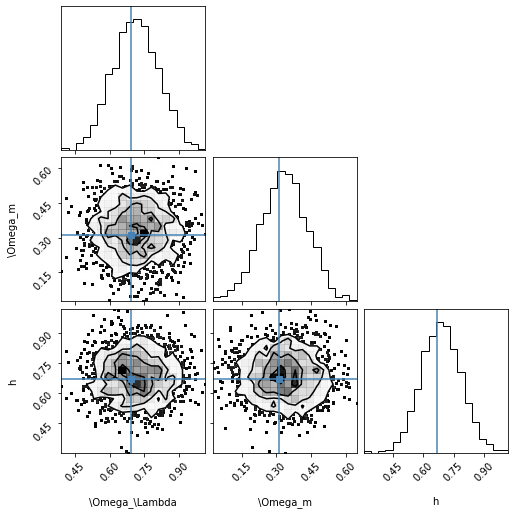

In [58]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[Omega_Lambda_guess, Omega_m_guess, h_guess]
)
plt.savefig('corner.png');

The corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.

Finally, we will compute the final parameter estimations as the 50-th percentile of the sample and the uncertainties as the difference between the 25-th,  75-th percentile and the 50-th percentile of the samples:

In [59]:
#Given a vector V of length N, the q-th percentile of V is the value q/100 of the way from the minimum to the maximum in a sorted copy of V
aux = []
for i in range(ndim):
    aux.append(np.percentile(flat_samples[:, i], [25, 50, 75])) # Compute the 25-th, 50-th and 75-th percentile of the data along the specified axis.
aux

[array([0.64537358, 0.71099674, 0.78152682]),
 array([0.26506677, 0.33268155, 0.39859803]),
 array([0.6221529 , 0.68712036, 0.7526445 ])]

In [60]:
# Store the percentiles in a array
mcmc = np.array([aux[0], aux[1], aux[2]*100])

In [61]:
from IPython.display import display, Math

for i in range(ndim):
    q = np.diff(mcmc[i]) # Calculate the n-th discrete difference along the given axis: a[i+1] - a[i]
    labels2 = ["\Omega_\Lambda", "\Omega_m", "H_0[{\r km/sMpc}]"]
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[i][1], q[0], q[1], labels2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**These are the final values estimated by the ensemble sampler emcee for the dark energy density $\Omega_\Lambda$, the mass density $\Omega_m$ and the Hubble parameter $H_0$.**

Let's calculate the theoretical curve using the parameters values estimated by the ensamble:

In [62]:
mu_ensemble = mu_model_pipe(mcmc[0][1], mcmc[1][1], mcmc[2][1]/100)

Text(0, 0.5, 'Distance Modulus')

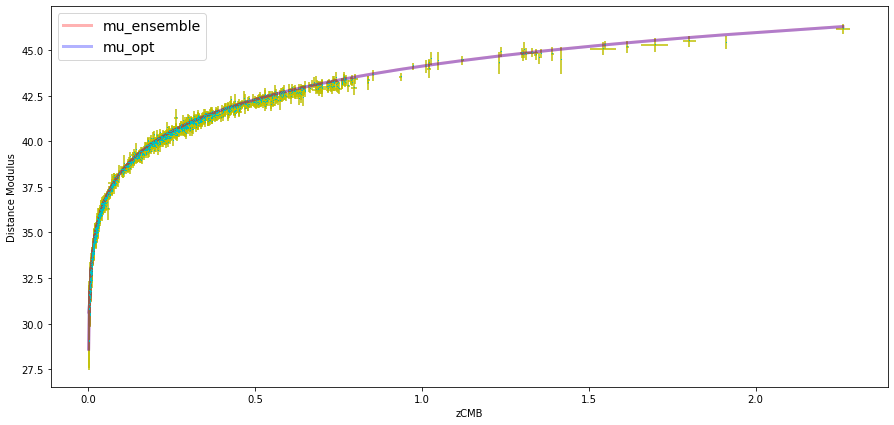

In [63]:
# Plot the mu_theoretical calculated using the parameters that maximize the likelihood
plt.figure(figsize=(15,7))

# Plot the error bars
z_exp=df['zCMB']
mu_exp=df['MU_SH0ES']
plt.errorbar(z_exp, mu_exp, xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt=",c", ecolor="y", capsize=0)

# Plot the theoretical model with ensamble generated parameters
plt.plot(z_var, mu_ensemble(z_exp), "r", alpha=0.3, lw=3, label="mu_ensemble")

# Plot the theoretical model with optimized likelihood parameters
plt.plot(z_var, mu_opt(z_var), "b", alpha=0.3, lw=3, label="mu_opt")

plt.legend(fontsize=14)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

In [64]:
# Creating a array of calculated mu data
mu_mod_ensemble = []
mu_mod_ensemble.append(mu_ensemble(z_exp))
mu_mod_ensemble = np.array(mu_mod_ensemble)

In [65]:
# Chi-square statistic  
#  sd : uncertainties in mu data (standard deviation) 
chisq_ensemble=np.sum(((mu_exp-mu_mod_ensemble[0])/np.std(mu_exp))**2) 

# Number of degrees of freedom nu equals the number of observations n minus the number of fitted parameters 
nu=mu_exp.size-3 

# Reduced Chi Squared Statistics
reduced_chisq_ensemble = chisq_ensemble/nu

In [66]:
reduced_chisq_ensemble

0.004810391628401367

In [67]:
residues_ensemble = mu_exp-mu_mod_ensemble[0]

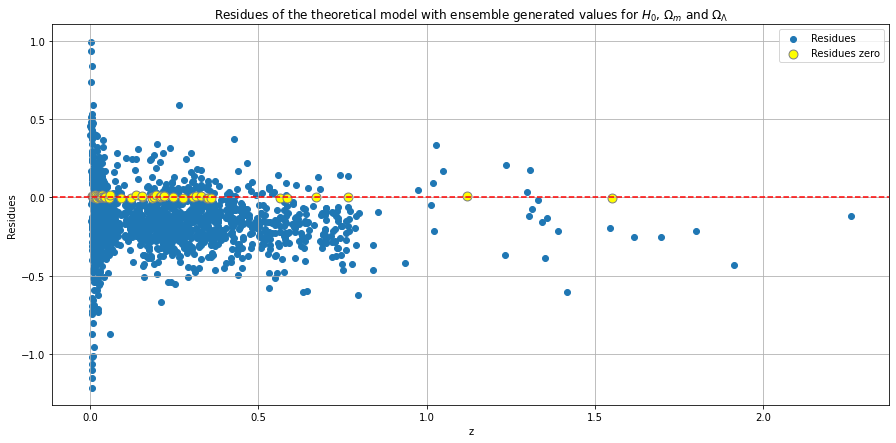

In [68]:
# Plot the residues
plt.figure(figsize=(15,7))

zero_indices = np.where((-0.01 <= residues_ensemble) & (residues_ensemble <= 0.01))[0]

plt.scatter(z_exp, residues_ensemble, label='Residues')
plt.axhline(0, color='red', linestyle='--')
plt.scatter(z_exp[zero_indices], residues[zero_indices], s=80, color='yellow', edgecolor='gray', label='Residues zero')

plt.xlabel('z')
plt.ylabel('Residues')
plt.title('Residues of the theoretical model with ensemble generated values for $H_0$, $\Omega_m$ and $\Omega_\Lambda$')

plt.legend()
plt.grid(True)

In [69]:
# Number of binned points
len(zero_indices)

51

## Trying to find an approximation simple function

In [70]:
# Trying to find an exact function approximation to \mu
def mu_try(z):
    return 1457 / 33 * z**(2/33)

Text(0, 0.5, 'Theoretical Distance Modulus')

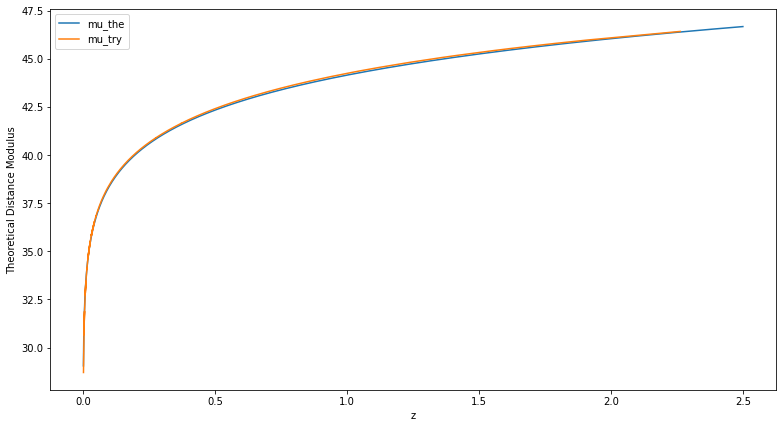

In [71]:
# Plot the numerical interpolation function of the theoretical model
plt.figure(figsize=(13,7))
z = np.arange(0.001,2.5,0.0014)
plt.plot(z, mu_try(z), label='mu')
plt.plot(z_var, mu_model_inter(z_var))
legend = ("mu_the","mu_try")
plt.legend(legend)
plt.xlabel("z")
plt.ylabel("Theoretical Distance Modulus")

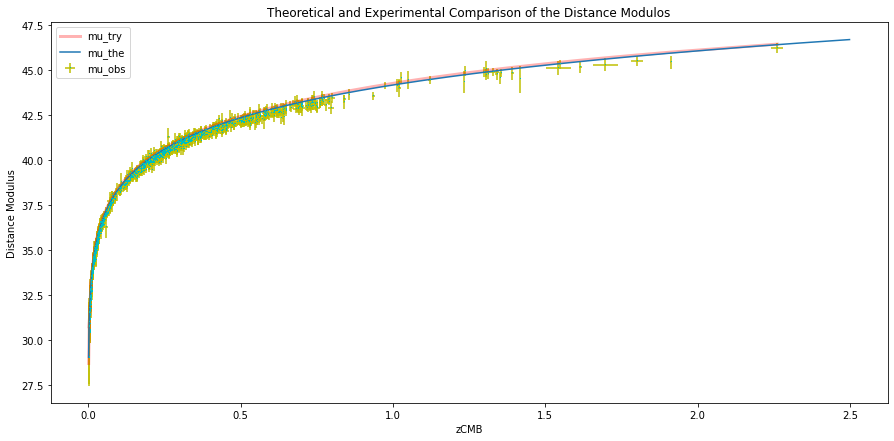

In [72]:
# Plot the theoretical experimental comparison of the distance modulos
plt.figure(figsize=(15,7))

# Plot the data points and error bars
x_exp=df['zCMB']
y_exp=df['MU_SH0ES']
plt.errorbar(x_exp, y_exp, xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt=",c", ecolor="y", capsize=0)

# Plot the true line
y_theo=mu_model_inter
plt.plot(x_exp, y_theo(x_exp), "r", alpha=0.3, lw=3)

# Plot mu try function
z = np.arange(0.001,2.5,0.0014)
plt.plot(z, mu_try(z), label='mu')

plt.title("Theoretical and Experimental Comparison of the Distance Modulos")
legend = ("mu_try","mu_the", "mu_obs")
plt.legend(legend)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")
plt.savefig('dist_modulus.png')

In [73]:
# Creating a array of calculated mu data
mu_mod_try = []
mu_mod_try.append(mu_try(z_exp))
mu_mod_try = np.array(mu_mod_try)

In [74]:
# Chi-square statistic  
#  sd : uncertainties in mu data (standard deviation) 
chisq_try=np.sum(((mu_exp-mu_mod_try[0])/np.std(mu_exp))**2) 

# Number of degrees of freedom nu equals the number of observations n minus the number of fitted parameters 
nu=mu_exp.size-3 

# Reduced Chi Squared Statistics
reduced_chisq_try = chisq_try/nu

In [75]:
reduced_chisq_try

0.0067056348654938236

In [76]:
residues_try = mu_exp-mu_mod_try[0]

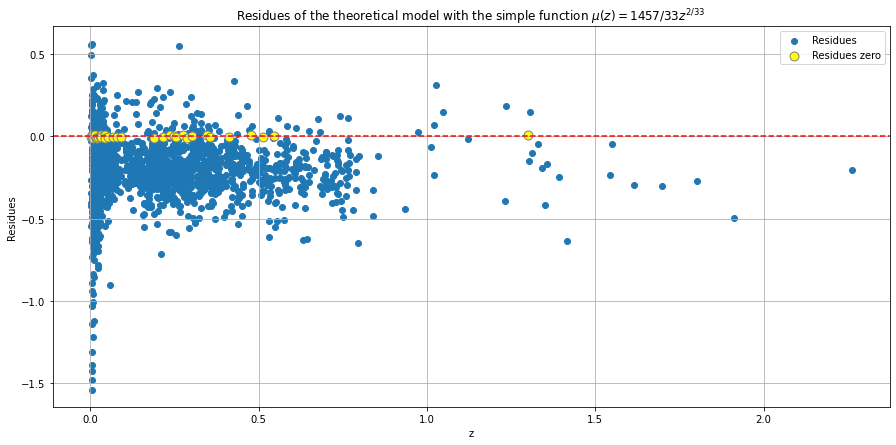

In [77]:
# Plot the residues
plt.figure(figsize=(15,7))

zero_indices = np.where((-0.01 <= residues_try) & (residues_try <= 0.01))[0]

plt.scatter(z_exp, residues_try, label='Residues')
plt.axhline(0, color='red', linestyle='--')
plt.scatter(z_exp[zero_indices], residues_try[zero_indices], s=80, color='yellow', edgecolor='gray', label='Residues zero')

plt.xlabel('z')
plt.ylabel('Residues')
plt.title('Residues of the theoretical model with the simple function $\mu(z) = 1457/33z^{2/33}$')

plt.legend()
plt.grid(True)

In [78]:
# Number of binned points
len(residues_try[zero_indices])

34

The function $\mu(z) = 1457/33z^{2/33}$ results in a bigger reduced chi-squared than the nummerical integration with the parametesr estimated by the ensemble samples. Also, the number of binned points is smaller than the other cases.

# Conclusion
We have analysed the supernova data from Phanteon+SH0ES collaboration to estimate the universe fractions of matter, vaccum energy and the the Hubble parameter using bayesian inference. These parameters was computed considering 10000 Markov Chains generated by 2000 walkers using the emcee implementation of the Monte Carlo algorithm. Since about 40 steps are needed for the chain to "forget" where it started we discarded the initial 100 steps. The final estimation choosen was the 50-th percentile of the flatted samples and the uncertainty the diference of the central value with the 25-th and the 75-th percentiles respectively. The final values encountered are:

In [79]:
for i in range(ndim):
    q = np.diff(mcmc[i]) # Calculate the n-th discrete difference along the given axis: a[i+1] - a[i]
    labels2 = ["\Omega_\Lambda", "\Omega_m", "H_0[{\r km/sMpc}]"]
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[i][1], q[0], q[1], labels2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

which agree with the direct observation of these parameters released by th Planck Satelite collaboration (2018): $H_0 = (67.4\pm0.5){\rm km/s/Mpc};  \Omega_m=0.315\pm0.007$ and $\Omega_\Lambda = 1 - \Omega_m$.

# References
* [Phanteon+SH0ES results 2021/2022](https://pantheonplussh0es.github.io/)
* [Library emcee documentation](https://emcee.readthedocs.io/en/stable/tutorials/line/)
* [Planck Satelite collaboration (2018)](https://arxiv.org/pdf/1807.06209.pdf)